In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bsoup
import json
import requests
import warnings
import re
from time import time
from IPython.core.display  import clear_output
from time import sleep
import seaborn as sns


warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50

/var/folders/d3/p20rjdgs7rsdm0_j85qwv1x80000gn/T/ipykernel_13879/1437413835.py:9: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display  import clear_output


In [2]:
#TODO: fix the recursive function looping

def get_teams_list(year, raw_data=False):
    url = f"http://lookup-service-prod.mlb.com/json/named.team_all_season.bam?sport_code='mlb'&all_star_sw='N'&sort_order=sort_by='name_asc'&season={year}"
    response = requests.get(url)
    if (response.ok):
#         print(response.ok)
        json_dict = response.json()
#         print(json_dict)
        teams_df_raw = pd.DataFrame.from_dict(json_dict['team_all_season']['queryResults']['row'])
#         print(teams_df_raw)
        teams_df = teams_df_raw[['team_id', 'name_display_full']]
#         print(teams_df)

        return_df = teams_df.copy()
        if raw_data:
            return_df = teams_df_raw.copy()
    return return_df

def get_team_roster(team, start, end=None, active=True, current=True):
    # if type(team) == 'str':
    year_team_id_keys = get_team_id_key(start)
    
    if end == None:
        end = start
    start_season = start
    end_season = end
    team_id = int(year_team_id_keys[team])

    url = f'http://lookup-service-prod.mlb.com/json/named.roster_team_alltime.bam?start_season={start}&end_season={end}&team_id={team_id}'
    response = requests.get(url)
    if (response.ok):
        json = response.json()
        json_dict = json['roster_team_alltime']['queryResults']['row']
        json_df = pd.DataFrame.from_dict(json_dict)
#         team_roster = 
    active='N'
    current='N'
    if active:
        active = 'Y'
        current_status = 'Active'
    if current:
        current = 'Y'
    json_df = json_df[(json_df.active_sw == active) & (json_df.current_sw == current) & (json_df.status_short == current_status)]
    json_df.set_index('player_id', inplace=True)
    return json_df

def get_team_id_key(year):
    teams_year = get_teams_list(year)
    teams_year.loc[:, 'name_display_full'] = teams_year.name_display_full.apply(lambda x: x.lower())

    teams = teams_year[['name_display_full', 'team_id']]
    teams_zipped = dict(zip(teams.name_display_full.apply(lambda x: x.lower()), teams.team_id))
#     teams_zipped['st. louis cardinals']
    return teams_zipped

def get_career_hitting(player_id):
    game_type = 'R'
    url = "http://lookup-service-prod.mlb.com/json/named.sport_career_hitting.bam?league_list_id='mlb'&game_type='R'&player_id=" + player_id
    response = requests.get(url)

    if (response.ok):
    #         print(response.ok)
        json_raw = response.json()
        json_dict = json_raw['sport_career_hitting']['queryResults']
    #     json_dict
    career_stats = pd.DataFrame.from_dict(json_dict)[['row']].T
    career_stats = career_stats.reset_index(drop=True)
    career_stats['player_id'] = player_id
    career_stats = career_stats.set_index('player_id')
    return career_stats

def get_active_roster_career_hitting(team, roster_year=2022, debug=False):
    cardinals_2022 = get_team_roster('st. louis cardinals', roster_year)
    if debug == True:
        print("get_active_roster_career_hitting\ncardinals_2022:\n")
        print(cardinals_2022)
    cardinals_active = cardinals_2022[[
    #     'player_id',
        'name_first_last',
        'position_desig',
        'primary_position',
        'throws',
        'bats',
        'status_short',
    ]]
    cardinals_active_fielders = cardinals_active[cardinals_active.position_desig != 'PITCHER']
    player_stats = pd.DataFrame()
    for id in list(cardinals_active_fielders.index):
        player_stats = pd.concat([player_stats, get_career_hitting(id)])

    return_df = cardinals_active_fielders.merge(player_stats, how='left', left_index=True, right_index=True)
    return_df['season'] = 'career'
    return return_df

def get_game_id_list(season):
    url = f'https://www.espn.com/mlb/team/schedule/_/name/stl/season/{season}/seasontype/2/half/1'

    response = requests.get(url)

    if (response.ok):
        data = response.content
        soup = bsoup(data, 'html.parser')

        links = table_tags = soup.select("a.AnchorLink")
        game_id_list = []
        for link in links:
    #         game_id = re.findall('.*/gameId/.*', link.text)
    #         print(str(link["href"]))
            if 'gameId' in str(link['href']):
    #             print(link['href'])
    #             print(str(link['href'])[-9:])
                game_id = str(link['href']).split('/')[-1]
#                 print(game_id)
                if game_id not in game_id_list:
                    game_id_list.append(game_id)
#     print(len(game_id_list))

    url = f'https://www.espn.com/mlb/team/schedule/_/name/stl/season/{season}/seasontype/2/half/2'

    response = requests.get(url)

    if (response.ok):
        data = response.content
        soup = bsoup(data, 'html.parser')

        links = table_tags = soup.select("a.AnchorLink")
    #     game_id_list = []
        for link in links:
    #         game_id = re.findall('.*/gameId/.*', link.text)
    #         print(str(link["href"]))
            if 'gameId' in str(link['href']):
    #             print(link['href'])
    #             print(str(link['href'])[-9:])
                game_id = str(link['href']).split('/')[-1]
#                 print(game_id)
                if game_id not in game_id_list:
                    game_id_list.append(game_id)
#     print(len(game_id_list))
    return game_id_list



# roster by season --> 2022

In [3]:
active_cardinals_career_hitting = get_active_roster_career_hitting('st.louis cardinals')
active_cardinals_career_hitting

,name_first_last,position_desig,primary_position,throws,bats,status_short,ab,ao,avg,babip,bb,cs,d,g,gidp,gidp_opp,go,go_ao,h,hbp,hfly,hgnd,hldr,hpop,hr,ibb,lob,np,obp,ops,ppa,r,rbi,roe,sac,sb,sf,slg,so,sport,sport_code,sport_id,t,tb,team_count,tpa,wo,xbh,season
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
571448,Nolan Arenado,INFIELDER,3B,R,R,Active,5266,1760,.288,.292,464,18,338,1383,156,942,1302,0.74,1519,32,329,409,776,5,299,69,2181,21461,.346,.881,3.68,803,967,44,5,23,61,.535,851,MLB,mlb,1,31,2816,2,5829,8,668,career
676475,Alec Burleson,OUTFIELDER,RF,L,L,Active,44,13,.182,.206,5,0,1,15,1,6,14,1.08,8,0,2,1,5,0,1,0,18,180,.265,.538,3.67,4,3,3,0,1,0,.273,9,MLB,mlb,1,0,12,1,49,0,2,career
666185,Dylan Carlson,OUTFIELDER,CF,L,S,Active,1081,280,.247,.304,109,4,68,311,14,144,266,0.95,267,18,57,73,136,1,29,3,454,4971,.323,.730,4.07,146,123,6,1,8,13,.407,281,MLB,mlb,1,9,440,1,1222,0,106,career
657557,Paul DeJong,INFIELDER,SS,R,R,Active,2150,631,.233,.277,192,9,107,616,41,360,425,0.67,501,43,127,124,247,3,102,4,964,9473,.306,.735,3.94,300,306,16,0,19,20,.429,627,MLB,mlb,1,4,922,1,2406,1,213,career
641512,Ben DeLuzio,OUTFIELDER,CF,R,R,Active,18,6,.167,.214,3,1,1,21,0,2,6,1.00,3,1,1,0,2,0,0,0,12,87,.318,.540,3.78,3,0,1,1,0,0,.222,4,MLB,mlb,1,0,4,1,23,0,1,career
572816,Corey Dickerson,OUTFIELDER,LF,R,L,Active,3523,955,.282,.325,220,24,230,1032,68,500,873,0.91,992,15,169,323,490,10,134,29,1384,14858,.325,.806,3.93,471,452,30,1,30,20,.481,771,MLB,mlb,1,36,1696,7,3782,4,400,career
680977,Brendan Donovan,INFIELDER,3B,R,L,Active,391,82,.281,.330,60,3,21,125,8,57,132,1.61,110,14,11,44,55,0,5,1,123,1966,.394,.773,4.20,64,45,4,1,2,2,.379,70,MLB,mlb,1,1,148,1,468,0,27,career
669242,Tommy Edman,INFIELDER,2B,R,S,Active,1744,470,.268,.307,116,13,95,458,21,236,501,1.07,468,23,65,180,219,4,40,3,589,7176,.321,.730,3.79,272,174,16,3,78,7,.409,315,MLB,mlb,1,15,713,1,1893,2,150,career
502671,Paul Goldschmidt,INFIELDER,1B,R,R,Active,5927,1367,.295,.349,916,33,382,1620,134,943,1414,1.03,1750,44,388,535,822,5,315,108,2314,28956,.391,.917,4.17,1045,1042,77,0,147,50,.527,1545,MLB,mlb,1,22,3121,2,6951,11,719,career


In [4]:
active_cardinals_career_stats_filtered = active_cardinals_career_hitting[[
# MLB glossary - https://www.mlb.com/glossary
    
    'name_first_last',
    'bats',
    'season',
#     'status_short',
# =================================================================================================================
    'ab', 
        # at bats
    'ao', 
        # fly-out
    'avg', 
        # batting avg
# =================================================================================================================
    'babip', 
        # Batting Average on Balls in Play: BABIP calculates a player’s batting average on balls hit into the field 
        # of play, excluding at bats that result in strikeouts, walks, or home runs.
        # When compared alongside AVG, this metric provides more context as to the type of hits a batter most often 
        # hits.
# =================================================================================================================
    'bb', 
        # walks
    'cs', 
        # caught stealing
    'gidp', 
        # ground in to double play
    'go', 
        # ground out
    'go_ao', 
        # ground-out, air-out
    'h', 
        # hits
    'hbp', 
        # hit by pitch
    'hfly', 
        # high fly ball rate?
    'hr', 
        # home runs
# =================================================================================================================
    'ibb',
        # Intentional Base on Balls: Also known as intentional walks, the total number of times a batter is 
        # intentionally given first base after four balls deliberately thrown by the pitcher. High IBB is a 
        # strong indirect indicator of slugging ability.
# =================================================================================================================
    'np',
        # Number of Pitches: When referring to a position player, NP indicates the total number of pitches 
        # thrown during their at-bats.
# =================================================================================================================
    'obp',
        # On-Base Percentage: Describes the percentage of time a batter advances to base as a result of hit, 
        # walk, or hit-by-pitch. Defined as (H+BB+HBP)/(AB+BB+HBP+SF), the stat provides a good general indicator 
        # of a player’s likelihood to reach base during an average at-bat.
# =================================================================================================================
    'ops',
        # OPS+ – On-Base Percentage + Slugging Plus: OPS+ attempts to normalize every player’s OPS rating across 
        # the entire league, accounting for external factors like ballparks and weighting numbers to as a perfect 
        # league average.
        # OPS+ simply improves the accuracy of OPS by adjusting for external factors, making it one of the best 
        # metrics bettors can use to evaluate a player’s potential at the plate.
# =================================================================================================================
    'ppa', 
        # pitches per plate appearance
# =================================================================================================================
    'r', 
        # Runs: The total number of runs the player has scored as a baserunner (safely reaching home plate).
# =================================================================================================================
    'rbi', 
        # RBI – Runs Batted In: The overall number of runs scored as a direct result of a player hitting the 
        #ball or being walked when at-bat.
# =================================================================================================================
    'sb', 
        # Bases Stolen: The total number of bases a player has stolen as a baserunner.
# =================================================================================================================
    'sf', 
        # SF – Sacrifice Flies: The number of times during the season a player has hit a fly-ball to the outfield or 
        # foul territory that allows a baserunner to score but results in an out for the player at bat.
# =================================================================================================================
    'slg', 
        # slugging, Describes a player’s power and productivity as hitter, as defined by total bases divided by at 
        # bats (TB/AB). Valuable for evaluating not only how often a player is likely to get a hit, but also the 
        # quality and relative value of those hits. Players with higher SLG are more likely to hit doubles, triples, 
        # and home runs.
# =================================================================================================================
    'so', 
        # Strikeouts: The number of times a player strikes out while at bat.
# =================================================================================================================
    'tb', 
        # Total Bases: The total number of bases a player has taken with their batting; tallies one for singles, two for 
        # doubles, three for triples.
# =================================================================================================================
    'xbh', 
        # Extra Base Hits: The total number of hits other than singles. Long hitters tend to have higher XBH values.
# =================================================================================================================
    'tpa', 
        # Total Plate Appearances: The number of completed turns at the plate a player has taken throughout the season. 
        # Unlike at-bats, which do not include plate appearances with certain results, PA tallies every single plate 
        # appearance regardless of outcome.

# =================================================================================================================
    'd', 
        #  Doubles: The number of times a player hits the ball and safely reaches second base without fielder error 
        # or sacrifice.
# =================================================================================================================
    't', 
        # Triples: The number of times a player hits the ball and safely reaches third base without fielder error or 
        # sacrifice.
# =================================================================================================================
    'g', 
        # games
# =================================================================================================================
    'sac',
        # SAC/SH – Sacrifice Bunts: The number of ‘sacrifice bunts’ or ‘sacrifice hits’ a player has made 
        # throughout the season. Only successful sacrifices are counted, so a baserunner must advance in order for 
        # the sacrifice to be tallied.
# =================================================================================================================
    'wo', 
        # walks-offs
# =================================================================================================================
    'gidp_opp',
# =================================================================================================================
    'roe', 
        # reached on error
        # https://www.mlb.com/glossary/standard-stats/reached-on-error
# =================================================================================================================
    'hgnd',
    'hldr',
    'hpop',
# =================================================================================================================
    'lob', 
        # left on base (runners)
]]

active_cardinals_career_stats_filtered

,name_first_last,bats,season,ab,ao,avg,babip,bb,cs,gidp,go,go_ao,h,hbp,hfly,hr,ibb,np,obp,ops,ppa,r,rbi,sb,sf,slg,so,tb,xbh,tpa,d,t,g,sac,wo,gidp_opp,roe,hgnd,hldr,hpop,lob
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
571448,Nolan Arenado,R,career,5266,1760,.288,.292,464,18,156,1302,0.74,1519,32,329,299,69,21461,.346,.881,3.68,803,967,23,61,.535,851,2816,668,5829,338,31,1383,5,8,942,44,409,776,5,2181
676475,Alec Burleson,L,career,44,13,.182,.206,5,0,1,14,1.08,8,0,2,1,0,180,.265,.538,3.67,4,3,1,0,.273,9,12,2,49,1,0,15,0,0,6,3,1,5,0,18
666185,Dylan Carlson,S,career,1081,280,.247,.304,109,4,14,266,0.95,267,18,57,29,3,4971,.323,.730,4.07,146,123,8,13,.407,281,440,106,1222,68,9,311,1,0,144,6,73,136,1,454
657557,Paul DeJong,R,career,2150,631,.233,.277,192,9,41,425,0.67,501,43,127,102,4,9473,.306,.735,3.94,300,306,19,20,.429,627,922,213,2406,107,4,616,0,1,360,16,124,247,3,964
641512,Ben DeLuzio,R,career,18,6,.167,.214,3,1,0,6,1.00,3,1,1,0,0,87,.318,.540,3.78,3,0,0,0,.222,4,4,1,23,1,0,21,1,0,2,1,0,2,0,12
572816,Corey Dickerson,L,career,3523,955,.282,.325,220,24,68,873,0.91,992,15,169,134,29,14858,.325,.806,3.93,471,452,30,20,.481,771,1696,400,3782,230,36,1032,1,4,500,30,323,490,10,1384
680977,Brendan Donovan,L,career,391,82,.281,.330,60,3,8,132,1.61,110,14,11,5,1,1966,.394,.773,4.20,64,45,2,2,.379,70,148,27,468,21,1,125,1,0,57,4,44,55,0,123
669242,Tommy Edman,S,career,1744,470,.268,.307,116,13,21,501,1.07,468,23,65,40,3,7176,.321,.730,3.79,272,174,78,7,.409,315,713,150,1893,95,15,458,3,2,236,16,180,219,4,589
502671,Paul Goldschmidt,R,career,5927,1367,.295,.349,916,33,134,1414,1.03,1750,44,388,315,108,28956,.391,.917,4.17,1045,1042,147,50,.527,1545,3121,719,6951,382,22,1620,0,11,943,77,535,822,5,2314


# historical player stats - hitting

In [5]:
active_cardinals_career_stats_filtered['r/g'] = active_cardinals_career_stats_filtered.r.astype('int') / active_cardinals_career_stats_filtered.g.astype('int')
active_cardinals_career_stats_filtered


,name_first_last,bats,season,ab,ao,avg,babip,bb,cs,gidp,go,go_ao,h,hbp,hfly,hr,ibb,np,obp,ops,ppa,r,rbi,sb,sf,slg,so,tb,xbh,tpa,d,t,g,sac,wo,gidp_opp,roe,hgnd,hldr,hpop,lob,r/g
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
571448,Nolan Arenado,R,career,5266,1760,.288,.292,464,18,156,1302,0.74,1519,32,329,299,69,21461,.346,.881,3.68,803,967,23,61,.535,851,2816,668,5829,338,31,1383,5,8,942,44,409,776,5,2181,0.580622
676475,Alec Burleson,L,career,44,13,.182,.206,5,0,1,14,1.08,8,0,2,1,0,180,.265,.538,3.67,4,3,1,0,.273,9,12,2,49,1,0,15,0,0,6,3,1,5,0,18,0.266667
666185,Dylan Carlson,S,career,1081,280,.247,.304,109,4,14,266,0.95,267,18,57,29,3,4971,.323,.730,4.07,146,123,8,13,.407,281,440,106,1222,68,9,311,1,0,144,6,73,136,1,454,0.469453
657557,Paul DeJong,R,career,2150,631,.233,.277,192,9,41,425,0.67,501,43,127,102,4,9473,.306,.735,3.94,300,306,19,20,.429,627,922,213,2406,107,4,616,0,1,360,16,124,247,3,964,0.487013
641512,Ben DeLuzio,R,career,18,6,.167,.214,3,1,0,6,1.00,3,1,1,0,0,87,.318,.540,3.78,3,0,0,0,.222,4,4,1,23,1,0,21,1,0,2,1,0,2,0,12,0.142857
572816,Corey Dickerson,L,career,3523,955,.282,.325,220,24,68,873,0.91,992,15,169,134,29,14858,.325,.806,3.93,471,452,30,20,.481,771,1696,400,3782,230,36,1032,1,4,500,30,323,490,10,1384,0.456395
680977,Brendan Donovan,L,career,391,82,.281,.330,60,3,8,132,1.61,110,14,11,5,1,1966,.394,.773,4.20,64,45,2,2,.379,70,148,27,468,21,1,125,1,0,57,4,44,55,0,123,0.512000
669242,Tommy Edman,S,career,1744,470,.268,.307,116,13,21,501,1.07,468,23,65,40,3,7176,.321,.730,3.79,272,174,78,7,.409,315,713,150,1893,95,15,458,3,2,236,16,180,219,4,589,0.593886
502671,Paul Goldschmidt,R,career,5927,1367,.295,.349,916,33,134,1414,1.03,1750,44,388,315,108,28956,.391,.917,4.17,1045,1042,147,50,.527,1545,3121,719,6951,382,22,1620,0,11,943,77,535,822,5,2314,0.645062


In [6]:
active_cardinals_career_stats_filtered.sort_values('r/g', ascending = False)

,name_first_last,bats,season,ab,ao,avg,babip,bb,cs,gidp,go,go_ao,h,hbp,hfly,hr,ibb,np,obp,ops,ppa,r,rbi,sb,sf,slg,so,tb,xbh,tpa,d,t,g,sac,wo,gidp_opp,roe,hgnd,hldr,hpop,lob,r/g
player_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
502671,Paul Goldschmidt,R,career,5927,1367,.295,.349,916,33,134,1414,1.03,1750,44,388,315,108,28956,.391,.917,4.17,1045,1042,147,50,.527,1545,3121,719,6951,382,22,1620,0,11,943,77,535,822,5,2314,0.645062
405395,Albert Pujols,R,career,11421,3516,.296,.284,1373,43,426,3474,0.99,3384,123,801,703,316,49879,.374,.918,3.82,1914,2218,117,123,.544,1404,6211,1405,13041,686,16,3080,1,22,2342,119,1038,1531,14,4912,0.621429
669242,Tommy Edman,S,career,1744,470,.268,.307,116,13,21,501,1.07,468,23,65,40,3,7176,.321,.730,3.79,272,174,78,7,.409,315,713,150,1893,95,15,458,3,2,236,16,180,219,4,589,0.593886
571448,Nolan Arenado,R,career,5266,1760,.288,.292,464,18,156,1302,0.74,1519,32,329,299,69,21461,.346,.881,3.68,803,967,23,61,.535,851,2816,668,5829,338,31,1383,5,8,942,44,409,776,5,2181,0.580622
680977,Brendan Donovan,L,career,391,82,.281,.330,60,3,8,132,1.61,110,14,11,5,1,1966,.394,.773,4.20,64,45,2,2,.379,70,148,27,468,21,1,125,1,0,57,4,44,55,0,123,0.512000
657557,Paul DeJong,R,career,2150,631,.233,.277,192,9,41,425,0.67,501,43,127,102,4,9473,.306,.735,3.94,300,306,19,20,.429,627,922,213,2406,107,4,616,0,1,360,16,124,247,3,964,0.487013
666185,Dylan Carlson,S,career,1081,280,.247,.304,109,4,14,266,0.95,267,18,57,29,3,4971,.323,.730,4.07,146,123,8,13,.407,281,440,106,1222,68,9,311,1,0,144,6,73,136,1,454,0.469453
572816,Corey Dickerson,L,career,3523,955,.282,.325,220,24,68,873,0.91,992,15,169,134,29,14858,.325,.806,3.93,471,452,30,20,.481,771,1696,400,3782,230,36,1032,1,4,500,30,323,490,10,1384,0.456395
663457,Lars Nootbaar,L,career,397,104,.229,.253,63,2,3,110,1.06,91,1,19,19,2,1846,.332,.770,3.94,67,55,6,6,.438,99,174,41,468,18,4,165,1,2,62,1,32,40,0,150,0.406061


# get info per game type

In [7]:
game_ids_2021 = get_game_id_list(2021)
# game_ids_2021

# get game data

In [8]:
# test_game_id = '401229470'

def get_game_id_boxscore(test_game_id):
    url = 'https://www.espn.com/mlb/boxscore/_/gameId/'

    url+=test_game_id

    response = requests.get(url)

    if (response.ok):
        data = response.content
        soup = bsoup(data, 'html.parser')

#         print(soup.prettify())

    stats_table = soup.find('div', class_='boxscore-2017__parallel')
    for child in stats_table.children:
    #     print('child-------')
        cardinals_boxscore = stats_table
        if 'Cardinals' in child.text:
#             print(child)
            cardinals_boxscore = child

    hitter_list = []
    hitters = cardinals_boxscore.select('td.name')
    for hitter in hitters:
        if hitter.text=='TEAM':
            break
        else:
    #         print(hitter.span)
            name = str(hitter.span)
            name = (name[6:-7].split('. '))
    #         name = name[6:-7]
            first = name[0].lower()
            last = name[1].lower()
            first_last = [last, first]
            hitter_list.append(first_last)

    hitting_stat_names = cardinals_boxscore.find_all('th')
    hitting_stat_list = []
    for stat in hitting_stat_names:
        if stat.text == 'Pitchers':
            break
        else:
#             print(stat.text)
            stat_text = stat.text
            if '#' in stat_text:
                stat_text = stat_text.replace('#', '')
            hitting_stat_list.append(stat_text.lower())

    hitters_df = pd.DataFrame(columns=hitting_stat_list[1:])
    # hitters_df.columns = hitting_stat_list
    hitters_df
    hitters_df['last'] = pd.Series(hitter_list).T
    new_list = []
    new_list_2 = []
    for item in list(hitters_df['last']):
#         print(item[0])
        new_list.append(item[0])
        new_list_2.append(item[1])
    hitters_df['last'] = new_list
    hitters_df['first_letter'] = new_list_2

    def add_stat_list(stat):
        hits_ab = []
        string = 'batting-stats-'+stat
        h_ab_list = cardinals_boxscore.find_all(class_=string)
        for item in h_ab_list[1:]:
#             print(item.text)
            hits_ab.append(item.text)
        hitters_df[stat] = pd.Series(hits_ab).T

    for item in hitting_stat_list[1:]:
        add_stat_list(item)
    hitters_df['game_id'] = test_game_id
    return hitters_df

In [9]:
start_time = time()
pages = 0
limit = len(game_ids_2021)

# while pages < limit:
    

num = 0
season_2021_df = pd.DataFrame()
for id_num in game_ids_2021:
    clear_output(wait=True)
    return_df = get_game_id_boxscore(id_num)
    season_2021_df = pd.concat([season_2021_df, return_df])
#     print(season_2021_df)
   







    sleep(0.1)
  
    # output some logs for monitoring
    elapsed_time = time() - start_time
    pages += 1
    print(f'Requests: {pages}, Frequency: {pages/elapsed_time} requests/s, {limit} strings processed.')

    print((str(pages)+'/' + str(limit))+' games processed...')

print('Processing complete!')


Requests: 162, Frequency: 1.0451090201719486 requests/s, 162 strings processed.
162/162 games processed...
Processing complete!


In [10]:
season_2021_df.head()

,h-ab,ab,r,h,rbi,hr,bb,k,p,avg,obp,slg,last,first_letter,game_id
0,1-5,5,1,1,0,0,0,0,23,.200,.200,.200,edman,t,401227063
1,4-5,5,3,4,1,0,0,0,17,.800,.800,1.200,goldschmidt,p,401227063
2,2-5,5,1,2,1,0,0,2,20,.400,.400,.400,arenado,n,401227063
3,1-5,5,1,1,1,0,0,1,14,.200,.200,.200,dejong,p,401227063
4,1-4,4,2,1,2,1,0,1,12,.250,.400,1.000,o'neill,t,401227063


In [11]:
season_2021_df['h'] = season_2021_df['h-ab'].apply(lambda x: x.split('-')[0])
season_2021_df['ab'] = season_2021_df['h-ab'].apply(lambda x: x.split('-')[1])
season_2021_df.drop(columns='h-ab', inplace=True)
season_2021_df.head()

,ab,r,h,rbi,hr,bb,k,p,avg,obp,slg,last,first_letter,game_id
0,5,1,1,0,0,0,0,23,.200,.200,.200,edman,t,401227063
1,5,3,4,1,0,0,0,17,.800,.800,1.200,goldschmidt,p,401227063
2,5,1,2,1,0,0,2,20,.400,.400,.400,arenado,n,401227063
3,5,1,1,1,0,0,1,14,.200,.200,.200,dejong,p,401227063
4,4,2,1,2,1,0,1,12,.250,.400,1.000,o'neill,t,401227063


In [12]:
int_list = ['ab', 'r', 'h', 'rbi', 'bb', 'k', 'p']
float_list = ['avg', 'obp', 'slg']

for col in int_list:
    season_2021_df[col] = season_2021_df[col].astype('int')
                   
for col in float_list:
    season_2021_df[col] = season_2021_df[col].astype('float')

season_2021_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2341 entries, 0 to 15
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ab            2341 non-null   int64  
 1   r             2341 non-null   int64  
 2   h             2341 non-null   int64  
 3   rbi           2341 non-null   int64  
 4   hr            2341 non-null   object 
 5   bb            2341 non-null   int64  
 6   k             2341 non-null   int64  
 7   p             2341 non-null   int64  
 8   avg           2341 non-null   float64
 9   obp           2341 non-null   float64
 10  slg           2341 non-null   float64
 11  last          2341 non-null   object 
 12  first_letter  2341 non-null   object 
 13  game_id       2341 non-null   object 
dtypes: float64(3), int64(7), object(4)
memory usage: 274.3+ KB


In [13]:
season_2021_df.groupby(['last'], as_index=False).agg(sum)

,last,ab,r,h,rbi,bb,k,p,avg,obp,slg
0,arenado,593,81,151,105,50,96,2472,43.006,51.226,79.919
1,bader,367,45,98,50,27,85,1605,25.971,32.947,46.457
2,cabrera,0,0,0,0,0,0,0,0.000,0.000,0.000
3,carlson,542,79,144,65,57,152,2538,38.656,51.613,65.989
4,carpenter,207,18,35,21,35,77,1124,18.919,37.484,34.313
5,dean,30,5,7,7,6,11,170,4.166,6.169,8.144
6,dejong,356,44,70,45,35,103,1578,20.990,32.492,43.880
7,dickson,0,0,0,0,0,0,0,0.000,0.000,0.000
8,edman,641,91,168,56,38,95,2616,42.164,50.320,60.819
9,elledge,2,0,0,0,0,0,5,0.000,0.000,0.000


In [14]:
active_last_names = active_cardinals_career_hitting.name_first_last.apply(lambda x: x.split(' ')[1].lower())
active_last_names = pd.DataFrame(active_last_names)
active_last_names

,name_first_last
player_id,
571448,arenado
676475,burleson
666185,carlson
657557,dejong
641512,deluzio
572816,dickerson
680977,donovan
669242,edman
502671,goldschmidt


In [15]:
season_2021_df[['h']]

,h
0,1
1,4
2,2
3,1
4,1
...,...
11,0
12,0
13,0
14,0


In [16]:
pivot_df = season_2021_df[['last', 'game_id', 'h']].pivot(columns='game_id')
pivot_df

last                                                        \
game_id    401227063    401227084    401227098      401227112    401227126   
0              edman        edman        edman          edman        edman   
1        goldschmidt  goldschmidt  goldschmidt    goldschmidt  goldschmidt   
2            arenado      arenado       miller        arenado      arenado   
3             dejong       dejong      arenado         dejong       dejong   
4            o'neill      o'neill         sosa        o'neill    carpenter   
5             molina       molina       dejong         molina        reyes   
6            carlson      carlson      o'neill        carlson       molina   
7           williams     williams       molina           dean      o'neill   
8           flaherty         dean      knizner       williams      carlson   
9               webb   wainwright      carlson  ponce de leon         gant   
10           helsley     woodford     williams          hicks     williams   
11           cabrera       miller     martinez      carpenter      helsley   
12         carpenter     nogowski    carpenter       gallegos      cabrera   
13          gallegos        hicks      helsley          reyes     nogowski   
14             reyes         webb         webb            NaN     gallegos   
15               NaN    carpenter      cabrera            NaN         webb   
16               NaN          NaN     nogowski            NaN         dean   
17               NaN          NaN          NaN            NaN          NaN   
18               NaN          NaN          NaN            NaN          NaN   
19               NaN          NaN          NaN            NaN          NaN   
20               NaN          NaN          NaN            NaN          NaN   

                                                                           \
game_id    401227140   401227149    401227169      401227184    401227203   
0              edman       edman        edman          edman        edman   
1        goldschmidt   carpenter  goldschmidt    goldschmidt  goldschmidt   
2            arenado      miller      arenado        arenado      arenado   
3             dejong    gallegos       dejong         molina       molina   
4          carpenter        dean     woodford         dejong      carlson   
5            cabrera       reyes      knizner        carlson       dejong   
6           nogowski     arenado       molina           dean    carpenter   
7              hicks      dejong      carlson         thomas       thomas   
8             molina      molina      o'neill  ponce de leon     williams   
9            o'neill     carlson         dean         oviedo         dean   
10           carlson    williams     williams      carpenter         gant   
11          flaherty     o'neill     martinez          hicks     gallegos   
12          williams  wainwright    carpenter           webb     nogowski   
13               NaN     helsley      helsley        cabrera       miller   
14               NaN    nogowski     nogowski       williams      helsley   
15               NaN         NaN         webb            NaN         webb   
16               NaN         NaN       miller            NaN      knizner   
17               NaN         NaN         sosa            NaN          NaN   
18               NaN         NaN          NaN            NaN          NaN   
19               NaN         NaN          NaN            NaN          NaN   
20               NaN         NaN          NaN            NaN          NaN   

                                                                            \
game_id      401227218    401227232    401227256    401227271    401227286   
0                edman        edman        edman        edman        edman   
1          goldschmidt  goldschmidt  goldschmidt  goldschmidt  goldschmidt   
2             nogowski      arenado      arenado      arenado      arenado   
3              arenado       molina       molina       moli

In [17]:
season_2021_df.drop(columns=['first_letter'], inplace=True)

In [18]:
full_season_stats = season_2021_df.pivot_table(index='last', columns='game_id')
full_season_stats = full_season_stats.T
full_season_stats

last           arenado  bader  cabrera  carlson  carpenter  dean  dejong  \
    game_id                                                                
ab  401227063    5.000    NaN      0.0    3.000      1.000   NaN   5.000   
    401227084    5.000    NaN      NaN    3.000      1.000   2.0   3.000   
    401227098    3.000    NaN      0.0    2.000      0.000   NaN   4.000   
    401227112    4.000    NaN      NaN    3.000      1.000   4.0   3.000   
    401227126    3.000    NaN      0.0    4.000      3.000   1.0   3.000   
...                ...    ...      ...      ...        ...   ...     ...   
slg 401229470    0.494  0.460      NaN    0.437      0.275   NaN     NaN   
    401324576    0.500  0.588      NaN    0.462      0.292   NaN   0.420   
    401337348    0.504    NaN      NaN    0.411        NaN   NaN   0.340   
    401346454    0.497  0.441      0.0      NaN        NaN   NaN   0.392   
    401362333    0.486  0.412      0.0    0.421      0.295   NaN     NaN   

last           dickson  edman  elledge  fernandez  flaherty  flores jr.  \
    game_id                                                               
ab  401227063      NaN  5.000      NaN        NaN     1.000         NaN   
    401227084      NaN  4.000      NaN        NaN       NaN         NaN   
    401227098      NaN  3.000      NaN        NaN       NaN         NaN   
    401227112      NaN  3.000      NaN        NaN       NaN         NaN   
    401227126      NaN  5.000      NaN        NaN       NaN         NaN   
...                ...    ...      ...        ...       ...         ...   
slg 401229470      NaN  0.387      NaN        NaN     0.294         NaN   
    401324576      NaN  0.423      NaN        NaN       NaN         NaN   
    401337348      NaN  0.384      NaN        NaN       NaN         NaN   
    401346454      NaN  0.390      NaN        NaN     0.294         NaN   
    401362333      NaN  0.397      NaN        NaN       NaN         NaN   

last           gallegos  gant  garcia  goldschmidt  happ  helsley  hicks  \
    game_id                                                                
ab  401227063       0.0   NaN     NaN        5.000   NaN      0.0    NaN   
    401227084       NaN   NaN     NaN        4.000   NaN      NaN    0.0   
    401227098       NaN   NaN     NaN        4.000   NaN      0.0    NaN   
    401227112       0.0   NaN     NaN        3.000   NaN      NaN    0.0   
    401227126       0.0   1.0     NaN        5.000   NaN      0.0    NaN   
...                 ...   ...     ...          ...   ...      ...    ...   
slg 401229470       NaN   NaN     NaN        0.514   NaN      NaN    NaN   
    401324576       0.0   NaN     NaN        0.398   NaN      0.0    NaN   
    401337348       NaN   NaN     NaN        0.419   NaN      NaN    NaN   
    401346454       NaN   NaN     NaN        0.515   NaN      NaN    NaN   
    401362333       0.0   NaN     0.0        0.495   NaN      NaN    NaN   

last           hudson  hurst    kim  knizner  leblanc  lester  martinez  \
    game_id                                                               
ab  401227063     NaN    NaN    NaN      NaN      NaN     NaN       NaN   
    401227084     NaN    NaN    NaN      NaN      NaN     NaN       NaN   
    401227098     NaN    NaN    NaN    2.000      NaN     NaN       1.0   
    401227112     NaN    NaN    NaN      NaN      NaN     NaN       NaN   
    401227126     NaN    NaN    NaN      NaN      NaN     NaN       NaN   
...               ...    ...    ...      ...      ...     ...       ...   
slg 401229470     NaN    NaN    NaN    0.236      NaN     NaN       NaN   
    401324576     NaN    NaN  0.167    0.277      NaN     NaN       NaN   
    401337348     NaN    NaN    NaN      NaN      NaN     NaN       NaN   
    401346454     0.5    NaN    NaN      NaN      NaN     NaN       NaN   
    401362333     NaN    NaN    NaN    0.254      NaN     NaN       NaN   

last           mcfarland  mikolas  miller  molina  moroff  nogowski  n

# test: projected run distributions

## projected: arenado

<AxesSubplot:xlabel='arenado', ylabel='Density'>

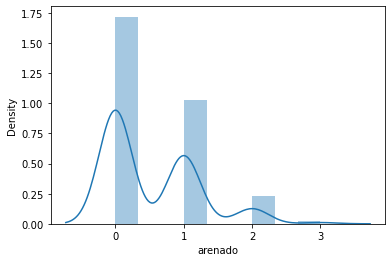

In [19]:
arenado_r = full_season_stats.arenado.r.dropna()
sns.distplot(arenado_r)

## projected: goldschmit

<AxesSubplot:ylabel='Density'>

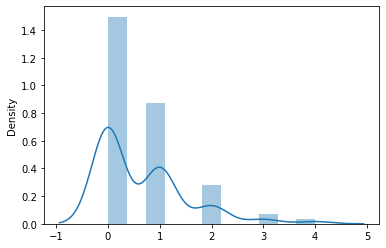

In [20]:
goldschmidt_r = full_season_stats.goldschmidt.r.dropna()

sns.distplot(goldschmidt_r.values)

In [21]:
full_season_stats.goldschmidt.r.sample(n=5)

game_id
401227696    0.0
401229432    NaN
401229344    2.0
401229155    0.0
401229057    0.0
Name: goldschmidt, dtype: float64

# fx: player_run_simulation

<AxesSubplot:ylabel='Density'>

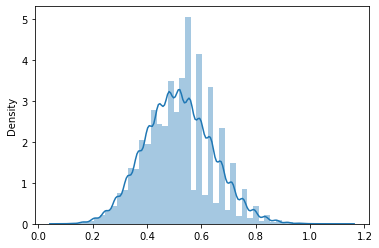

In [22]:
def player_run_simulation(player, n, x, full_stats):
    run_simulations = []
    sims = 0
    while sims < n:
        sample = full_stats[player].r.sample(x)
        run_simulations.append(sample.mean())
        sims+=1
    return run_simulations
sample_dist = player_run_simulation('arenado', 100000, 25, full_season_stats)

sns.distplot(sample_dist)

In [23]:
get_teams_list(2022)

,team_id,name_display_full
0,109,Arizona Diamondbacks
1,144,Atlanta Braves
2,110,Baltimore Orioles
3,111,Boston Red Sox
4,112,Chicago Cubs
5,145,Chicago White Sox
6,113,Cincinnati Reds
7,114,Cleveland Guardians
8,115,Colorado Rockies
9,116,Detroit Tigers


# upcoming game simulation test

### get pregame roster

In [24]:
game_id_list = get_game_id_list(2022)
game_id_list

['401421332',
 '401354275',
 '401354290',
 '401354311',
 '401354342',
 '401354357',
 '401354372',
 '401354387',
 '401354412',
 '401354427',
 '401354438',
 '401354453',
 '401354468',
 '401354483',
 '401354491',
 '401354503',
 '401354518',
 '401354522',
 '401354536',
 '401354551',
 '401354566',
 '401430260',
 '401354598',
 '401354613',
 '401354623',
 '401354637',
 '401354652',
 '401354667',
 '401354681',
 '401354696',
 '401354711',
 '401354732',
 '401354747',
 '401354762',
 '401439177',
 '401354790',
 '401354805',
 '401354812',
 '401354825',
 '401354840',
 '401354855',
 '401354870',
 '401354885',
 '401354905',
 '401354917',
 '401354932',
 '401354947',
 '401354962',
 '401354976',
 '401354991',
 '401355004',
 '401355020',
 '401423225',
 '401355035',
 '401355050',
 '401355069',
 '401355084',
 '401355097',
 '401355103',
 '401355118',
 '401355133',
 '401355152',
 '401429993',
 '401355166',
 '401355181',
 '401355205',
 '401355220',
 '401355235',
 '401355245',
 '401355259',
 '401355274',
 '4013

In [25]:
# class = Table__TBODY

In [26]:
# set the base url for the request
date = '2022-10-05'
url = f'https://www.mlb.com/cardinals/roster/starting-lineups/{date}'

response = requests.get(url)

if (response.ok):
    data = response.content
    soup = bsoup(data, 'html.parser')
    

In [34]:
away_team_abbrev = soup.find('div', class_='starting-lineups__teams--away-head').text
home_team_abbrev = soup.find('div', class_='starting-lineups__teams--home-head').text

In [41]:
away_team = away_team_abbrev.strip().split(' ')[0]
home_team = home_team_abbrev.strip().split(' ')[0]

In [88]:
roster = soup.find_all('li', class_='starting-lineups__player')
away = []
home = []
player_num = 1
for player in roster:
#     print(player.text)
    if player_num <=9:
        away.append(player.text.split(" "))
    elif player_num <=18:
        home.append(player.text.split(' '))
    player_num+=1
away_df = pd.DataFrame(away, columns=['first_name', 'last_name', 'bats', 'pos'])
home_df = pd.DataFrame(home, columns=['first_name', 'last_name', 'bats', 'pos', 'missing']).drop(columns='missing')

In [89]:
away_df.last_name = away_df.last_name.apply(lambda x: x.lower())
away_df.first_name = away_df.first_name.apply(lambda x: x.lower())

home_df.last_name = home_df.last_name.apply(lambda x: x.lower())
home_df.first_name = home_df.first_name.apply(lambda x: x.lower())

### away roster

In [90]:
away_roster = away_df[['last_name', 'first_name']]
away_roster

,last_name,first_name
0,nootbaar,lars
1,edman,tommy
2,arenado,nolan
3,dickerson,corey
4,yepez,juan
5,burleson,alec
6,carlson,dylan
7,knizner,andrew
8,dejong,paul


### get player_id for each playe ron roster

In [123]:
def get_player_id(first_name, last_name):
    # lookup_player
#     first_name = 'corey'
#     last_name = 'dickerson'
    name_part = "'" + first_name + " " + last_name + "'"
    print(name_part)
    url = "http://lookup-service-prod.mlb.com/json/named.search_player_all.bam?sport_code='mlb'&active_sw='Y'&name_part="+str(name_part)
    response = requests.get(url)
    if (response.ok):
    #     print(response.ok)
        json_dict = response.json()
    player_id = int(json_dict['search_player_all']['queryResults']['row']['player_id'])
    return player_id

get_player_id('corey', 'dickerson')

'corey dickerson'


572816

### home roster

In [84]:
home_roster = home_df[['last_name', 'first_name']]
home_roster

,last_name,first_name
0,kevin,newman
1,rodolfo,castro
2,ke'bryan,hayes
3,miguel,andujar
4,oneil,cruz
5,diego,castillo
6,jack,suwinski
7,jason,delay
8,ji,hwan
